In [20]:
import numpy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
from autogluon.tabular import TabularDataset, TabularPredictor

label = "isSignal"

features = [
    "tfRedChiSqB0", 
    "deltaE", 
    "invM_K_pi_shifted",
    "K_p_kaonID", 
    "K_p_dr", 
    "K_p_dz", 
    "pi_m_dr", 
    "pi_m_dz", 
    "mu_p_dr", 
    "mu_p_dz", 
    "mu_p_muonID", 
    "mu_m_dr", 
    "mu_m_dz", 
    "mu_m_muonID",
]


variables = ["q_squared", "costheta_mu", "costheta_K", "chi"]


mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["figure.dpi"] = 400
mpl.rcParams["axes.titlesize"] = 8
mpl.rcParams["figure.titlesize"] = 8
mpl.rcParams["figure.labelsize"] = 30
mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"\usepackage{bm}\usepackage{amsmath}"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = ["Computer Modern"]
mpl.rcParams["font.size"] = 8
mpl.rcParams["axes.titley"] = None
mpl.rcParams["axes.titlepad"] = 2
mpl.rcParams["legend.fancybox"] = False
mpl.rcParams["legend.framealpha"] = 0
mpl.rcParams["legend.markerscale"] = 1
mpl.rcParams["legend.fontsize"] = 11.5

In [13]:
training_dataset = TabularDataset(pandas.read_parquet("sb_train.parquet"))
training_dataset[label] = training_dataset[label].fillna(value=0)

validation_signal_region_dataset = TabularDataset(pandas.read_parquet("sr_val.parquet"))
validation_signal_region_dataset[label] = validation_signal_region_dataset[label].fillna(value=0)

validation_sideband_dataset = TabularDataset(pandas.read_parquet("sb_val.parquet"))
validation_sideband_dataset[label] = validation_sideband_dataset[label].fillna(value=0)

In [14]:
predictor = TabularPredictor(label=label).fit(training_dataset[features+[label]], time_limit=1200, presets="best")

No path specified. Models will be saved in: "AutogluonModels\ag-20250826_021643"
Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       35.13 GB / 63.10 GB (55.7%)
Disk Space Avail:   954.00 GB / 1862.07 GB (51.2%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identif

In [ ]:
predictor = TabularPredictor.load("AutogluonModels/ag-20250826_021643")

In [15]:
preds_sr_val = predictor.predict_proba(validation_signal_region_dataset.drop(columns=[label])[features])
preds_sr_val_signal = preds_sr_val[validation_signal_region_dataset[label] == 1][1]
preds_sr_val_bkg = preds_sr_val[validation_signal_region_dataset[label] == 0][1]

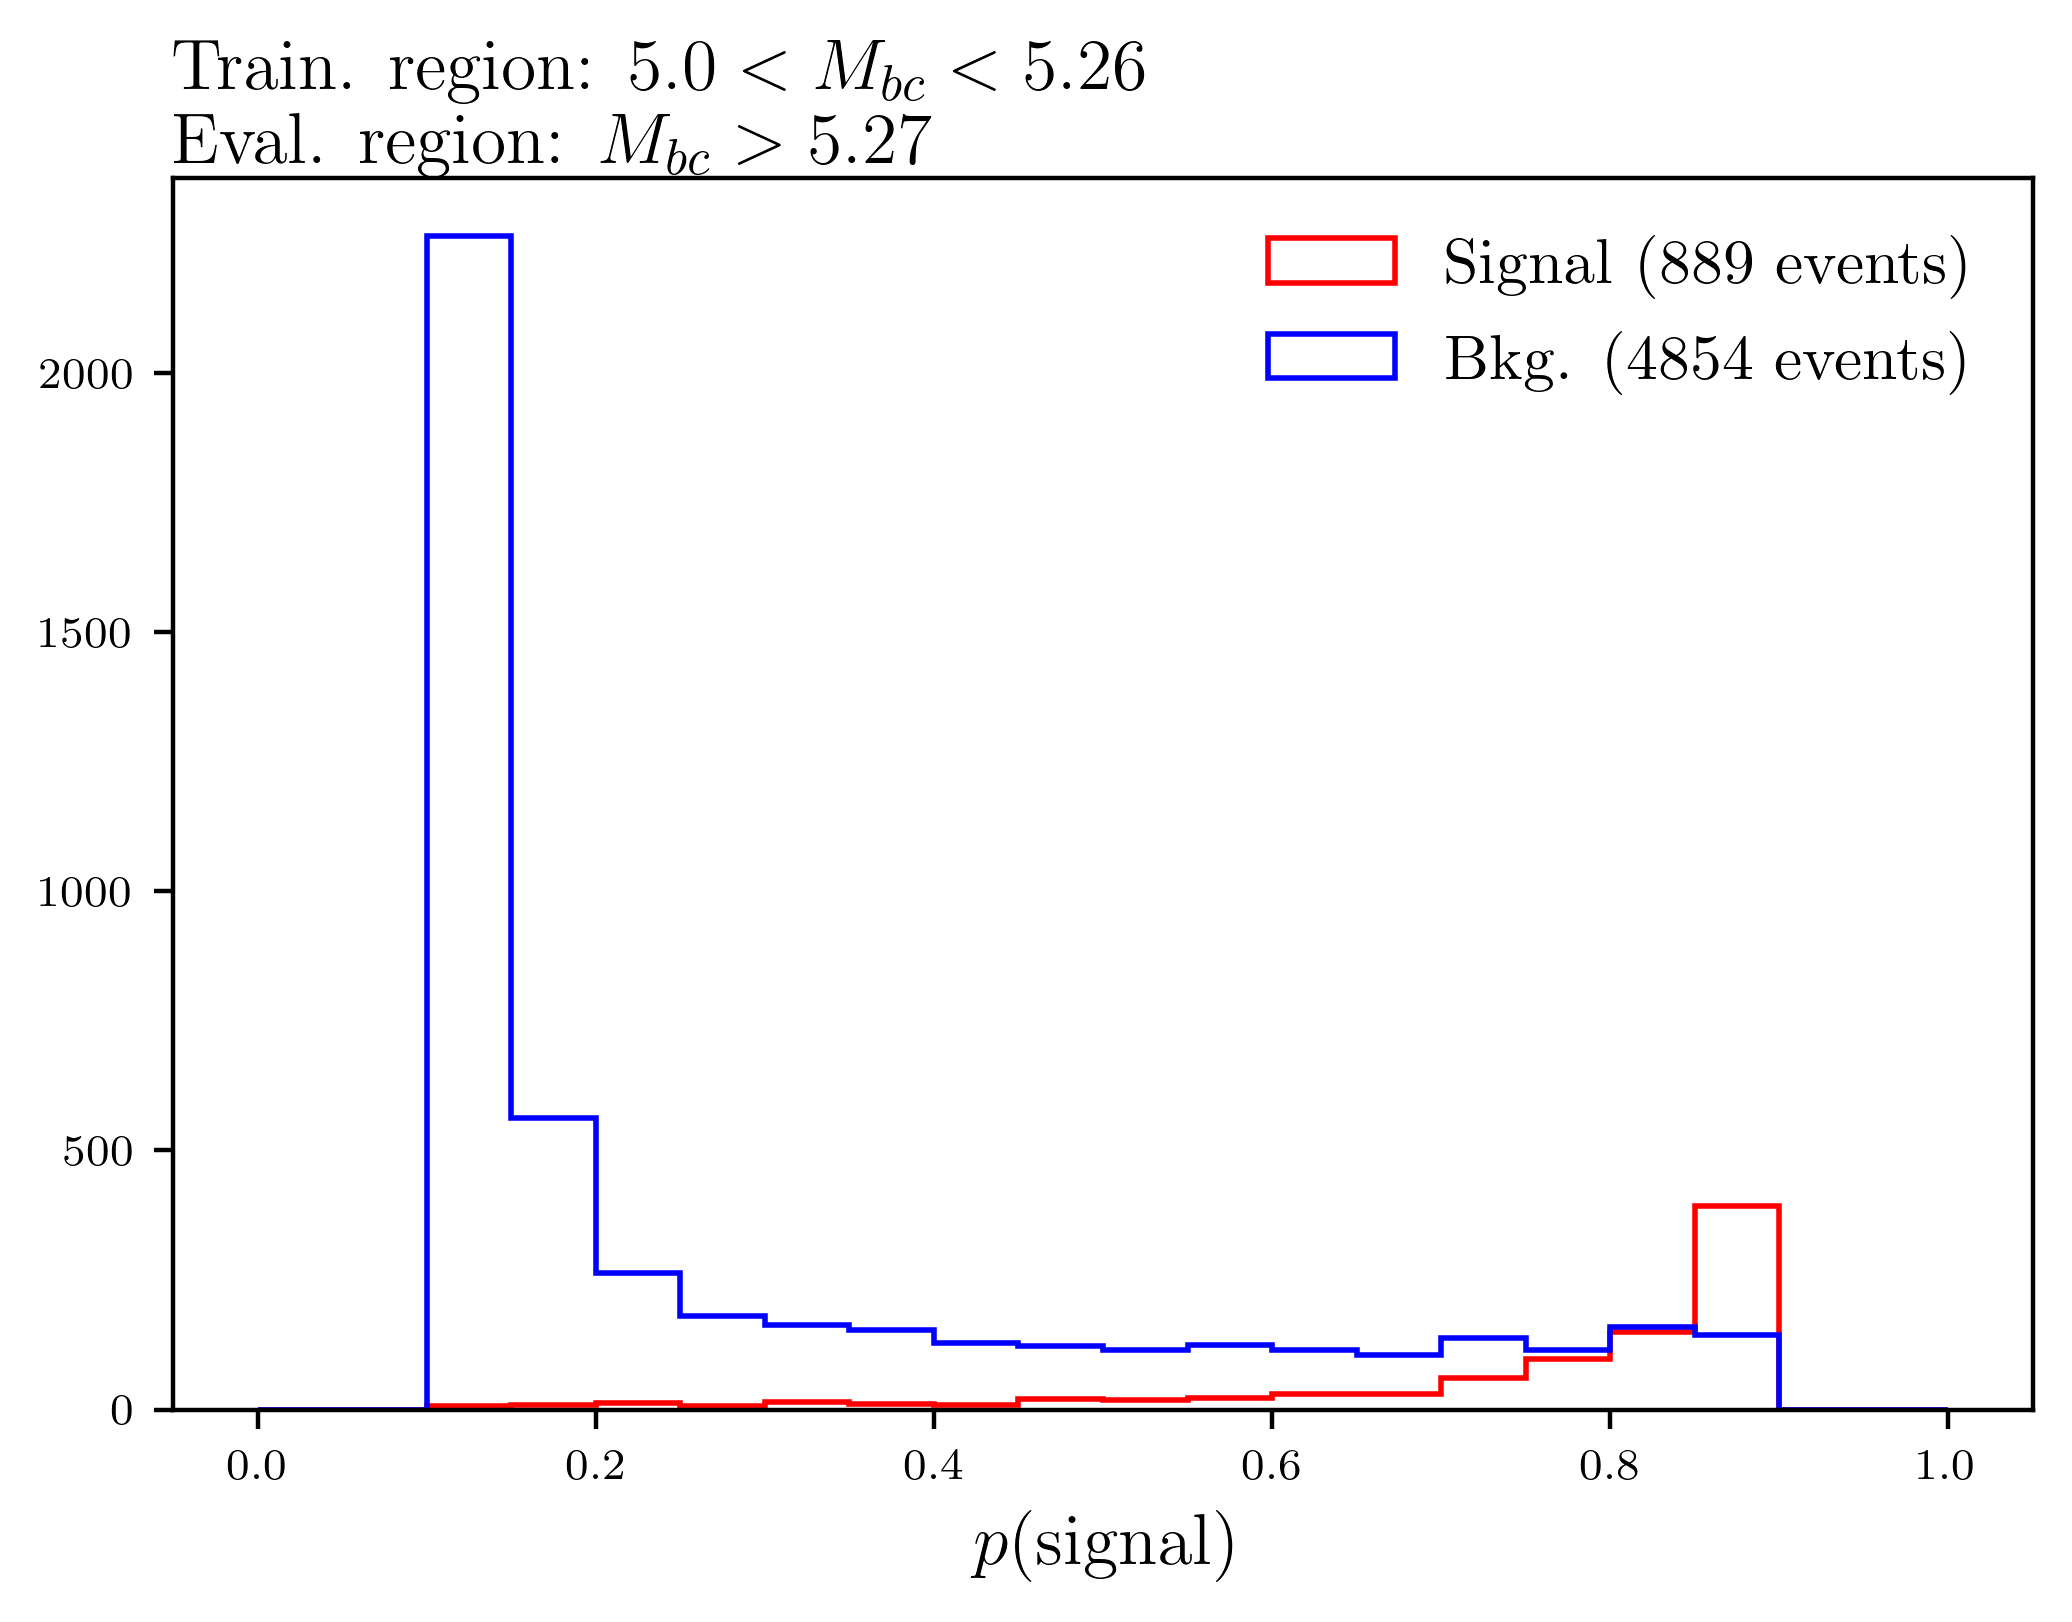

In [16]:
plt.hist(preds_sr_val_signal, label=f"Signal ({len(preds_sr_val_signal)} events)", color="red", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.hist(preds_sr_val_bkg, label=f"Bkg. ({len(preds_sr_val_bkg)} events)", color="blue", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.title(r"Train. region: $ 5.0 < M_{bc} < 5.26$"+"\n"+ r"Eval. region: $M_{bc} > 5.27$", loc="left", fontsize=13)
plt.xlabel(r"$p(\text{signal})$", fontsize=13)
plt.legend()
plt.savefig("bkg_sup_sb_sr", bbox_inches="tight")

In [17]:
p_thresholds = numpy.linspace(0, 1, 130)

signal_counts = numpy.array([len(preds_sr_val_signal[preds_sr_val_signal > thresh]) for thresh in p_thresholds])
bkg_counts = numpy.array([len(preds_sr_val_bkg[preds_sr_val_bkg > thresh]) for thresh in p_thresholds])
ratio_bkg_to_signal = bkg_counts / signal_counts

fig, axs = plt.subplots(2,  1, sharex=True, layout="compressed")

axs.flat[0].scatter(p_thresholds, ratio_bkg_to_signal, color="purple", s=3)
axs.flat[0].set_ylabel(r"$n_\text{bkg} / n_\text{sig}$", fontsize=13)
axs.flat[0].set_ylim(bottom=0)

axs.flat[1].set_xlabel("Cut Threshold", fontsize=13, labelpad=13)
axs.flat[1].set_ylabel(r"$n_\text{sig} / \sqrt{n_\text{sig} + n_\text{bkg}}$", fontsize=13)
axs.flat[1].scatter(p_thresholds, signal_counts/numpy.sqrt(signal_counts+bkg_counts), color="red", s=3)
axs.flat[1].set_ylim(bottom=5)

plt.savefig("bkg_sup_ratio.png", bbox_inches="tight")
plt.close()


C:\Users\tetha\AppData\Local\Temp\ipykernel_498796\1522873047.py:5: RuntimeWarning: invalid value encountered in divide
  ratio_bkg_to_signal = bkg_counts / signal_counts
C:\Users\tetha\AppData\Local\Temp\ipykernel_498796\1522873047.py:15: RuntimeWarning: invalid value encountered in divide
  axs.flat[1].scatter(p_thresholds, signal_counts/numpy.sqrt(signal_counts+bkg_counts), color="red", s=3)


In [18]:
preds_sb_val = predictor.predict_proba(validation_sideband_dataset.drop(columns=[label])[features])
preds_sb_val_signal = preds_sb_val[validation_sideband_dataset[label] == 1][1]
preds_sb_val_bkg = preds_sb_val[validation_sideband_dataset[label] == 0][1]

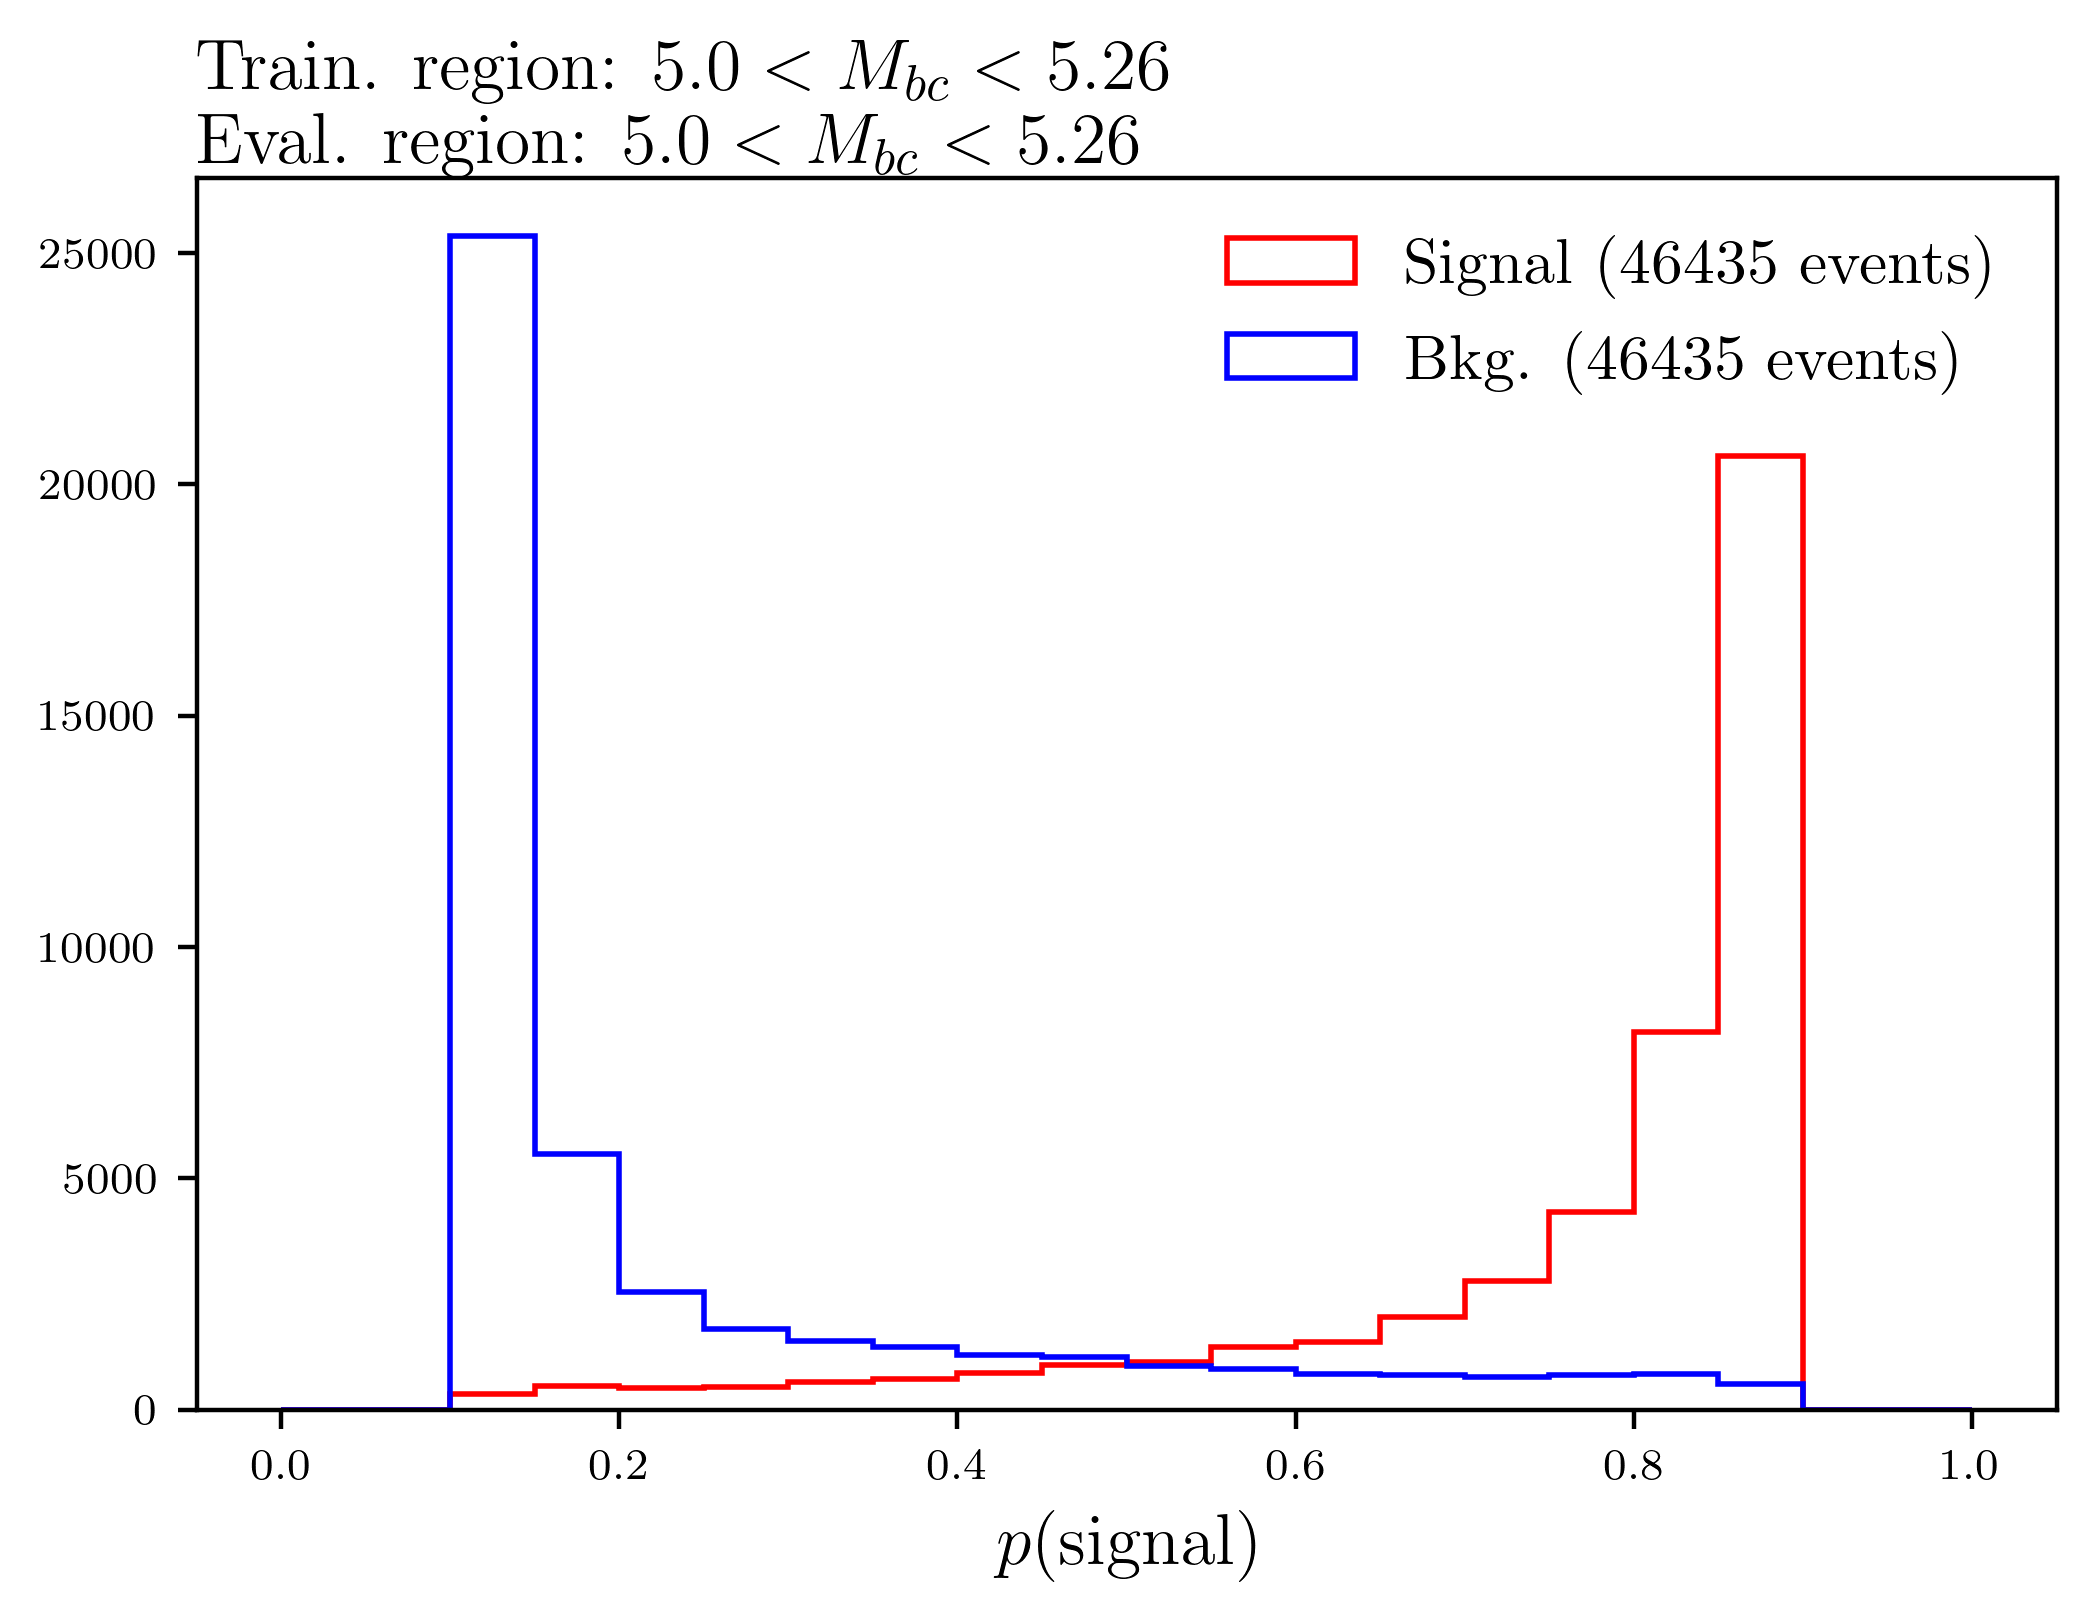

2025-08-25 16:38:57,470	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-08-25 16:38:57,472	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-08-25 16:38:57,473	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-08-25 16:38:57,474	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-08-25 16:38:57,476	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UN

In [ ]:
plt.hist(preds_sb_val_signal, label=f"Signal ({len(preds_sb_val_signal)} events)", color="red", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.hist(preds_sb_val_bkg, label=f"Bkg. ({len(preds_sb_val_bkg)} events)", color="blue", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.title(r"Train. region: $ 5.0 < M_{bc} < 5.26$"+"\n"+ r"Eval. region: $ 5.0 < M_{bc} < 5.26$", loc="left", fontsize=13)
plt.xlabel(r"$p(\text{signal})$", fontsize=13)
plt.legend()
plt.savefig("bkg_sup_sb_sb", bbox_inches="tight")

In [ ]:
preds_sb_train = predictor.predict_proba(training_dataset.drop(columns=[label])[features])
preds_sb_train_signal = preds_sb_train[training_dataset[label] == 1][1]
preds_sb_train_bkg = preds_sb_train[training_dataset[label] == 0][1]

In [ ]:
plt.hist(preds_sb_train_signal, label=f"Signal ({len(preds_sb_train_signal)} events)", color="red", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.hist(preds_sb_train_bkg, label=f"Bkg. ({len(preds_sb_train_bkg)} events)", color="blue", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.title(r"Train. region: $ 5.0 < M_{bc} < 5.26$"+"\n"+ r"Eval. region: $ 5.0 < M_{bc} < 5.26$", loc="left", fontsize=13)
plt.xlabel(r"$p(\text{signal})$", fontsize=13)
plt.legend()
plt.savefig("bkg_sup_sb_sb_train", bbox_inches="tight")

In [ ]:
for i in preds_sb_train_signal, preds_sb_val_signal, preds_sr_val_signal:
    print(i.min())

In [ ]:
intervals = {
    "isSignal" : (-1, 2),
    "tfRedChiSqB0" : (-2, 20), 
    "deltaE" : (-0.1, 0.1),
    "invM_K_pi_shifted" : (-0.25, 0.25),
    "K_p_kaonID" : (0.99, 1),
    "K_p_dr" : (0, 0.03),
    "K_p_dz" : (-0.25, 0.25),
    "pi_m_dr" : (0, 0.05),
    "pi_m_dz" : (-0.25, 0.25),
    "mu_p_dr" : (0, 0.03),
    "mu_p_dz" : (-0.25, 0.25),
    "mu_p_muonID" : (0.999, 1),
    "mu_m_dr" : (0, 0.03),
    "mu_m_dz" : (-0.25, 0.25),
    "mu_m_muonID" : (0.999, 1)
}

xlabels = {
    "isSignal" : "isSignal",
    "tfRedChiSqB0" : r"Tree Fitter $\chi^2_\text{red}$", 
    "deltaE" : r"$\Delta E$",
    "invM_K_pi_shifted" : r"$M_{\text{inv}\,K\,\pi}$",
    "K_p_kaonID" : r"$K^+$: KaonID",
    "K_p_dr" : r"$K^+$: $dr$",
    "K_p_dz" : r"$K^+$: $dz$",
    "pi_m_dr" : r"$pi^-$: $dr$",
    "pi_m_dz" : r"$pi^-$: $dz$",
    "mu_p_dr" : r"$\mu^+$: $dr$",
    "mu_p_dz" : r"$\mu^+$: $dz$",
    "mu_p_muonID" : r"$\mu^+$: muonID",
    "mu_m_dr" : r"$\mu^-$: $dr$",
    "mu_m_dz" : r"$\mu^-$: $dz$",
    "mu_m_muonID" : r"$\mu^-$: muonID"
}

bins = 20

for var in validation_dataset.columns:

    val_bkg = validation_dataset[validation_dataset[label]==0]
    val_sig = validation_dataset[validation_dataset[label]==1]
    train_bkg = training_dataset[training_dataset[label]==0]
    train_sig = training_dataset[training_dataset[label]==1]

    plt.hist(val_bkg[var], color="purple", linestyle="--", histtype="step", label="Bkg. (Val.)", density=True, bins=bins, range=intervals[var])
    # plt.hist(val_sig[var], color="orange", linestyle="--", histtype="step", label="val_sig", density=True, bins=20, range=intervals[var])
    plt.hist(train_bkg[var], color="red", histtype="step", label="Bkg. (Train.)", density=True, bins=bins, range=intervals[var])
    plt.hist(train_sig[var], color="blue", histtype="step", label="Signal", density=True, bins=bins, range=intervals[var])
    plt.legend()
    plt.xlabel(xlabels[var], fontsize=14)
    plt.savefig(f"{var}.png", bbox_inches="tight")
    plt.close()

In [29]:
intervals = {
    "q_squared" : (0, 20),
    "costheta_mu" : (-1, 1),
    "costheta_K"  : (-1, 1),
    "chi" : (0, 2*numpy.pi)
}

xlabels = {
    "q_squared" : r"$q^2$",
    "costheta_mu" : r"$\cos\theta_\mu$",
    "costheta_K"  : r"$\cos\theta_K$",
    "chi" : r"$\chi$"
}

bins = 20

bkg_sup_sr = validation_sideband_dataset[preds_sb_val[1] > 0.7]
# bkg_sup_sr = validation_signal_region_dataset[preds_sr_val[1] > 0.7]
bkg_sup_sb = validation_sideband_dataset[preds_sb_val[1] < 0.7]

bkg_sup_sr_bkg = bkg_sup_sr[bkg_sup_sr["isSignal"] == 0]
bkg_sup_sb_bkg = bkg_sup_sb[bkg_sup_sb["isSignal"] == 0]

for var in variables:

    plt.hist(bkg_sup_sr_bkg[var], color="red", histtype="step", label="SR", density=True, bins=bins, range=intervals[var])
    plt.hist(bkg_sup_sb_bkg[var], color="blue", histtype="step", label="SB", density=True, bins=bins, range=intervals[var])
    plt.legend()
    plt.xlabel(xlabels[var], fontsize=14)
    plt.savefig(f"{var}_sb_sr_bkg.png", bbox_inches="tight")
    plt.close()

In [22]:
preds_sr_val[1]

509    0.115025
26     0.317449
14     0.846490
56     0.559379
829    0.104387
         ...   
125    0.876056
423    0.785138
97     0.888144
479    0.390619
17     0.884973
Name: 1, Length: 5743, dtype: float64